In [1]:
import sys
import os
import pandas as pd
from pytablewriter import MarkdownTableWriter
from typing import Dict, List, Any

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

%config Completer.use_jedi = False


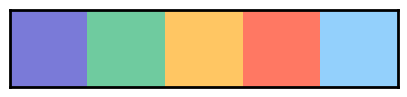

In [2]:

sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_context("paper", font_scale=1.5)

plt.rcParams.update({'axes.edgecolor': 'black', 'axes.linewidth': 2, 
                     'axes.grid': False, 'grid.linestyle': '--'})
colors = ['#7a7ad8', '#6fcb9f', '#ffc663', '#ff7863', '#93d0fc']
sns.palplot(colors)
sns.set_palette(sns.color_palette(colors), 8, .75)
sub_figure_title = {"fontweight": 700, 'fontname':'Arial', 'fontsize': 18}
#plt.tight_layout()


In [3]:
#ALGORITHM = ["semantic-zest", "syntactic-zest", "semantic-noguidance", "syntactic-noguidance"]
ALGORITHM = ["semantic-zest", "syntactic-zest", "semantic-noguidance", "syntactic-noguidance","afl"]

RANGE=20 #exclusive range in python


In [4]:
#path = "/home/alena/source/growe/exps8"

folder = "expfinal3"
base_path = f"c:\\Users\\Alena\\source\\repos\\growe\\{folder}\\"


In [5]:

def process_cov_data(path: str) -> List[str]:
    with open(path) as f:
        return f.readlines()

def add_rolling_mean( data : pd.DataFrame, rolling : int = 10) -> pd.DataFrame:
    data['valid_inputs_percent']= data['valid_inputs'] / data['total_inputs']

    # rolling mean to valid_covered_probes
    data[f'rolling_{rolling}_valid_covered_probes'] = data['valid_covered_probes'].rolling(rolling).mean()
    
    # rolling mean to all_covered_probes
    data[f'rolling_{rolling}_all_covered_probes'] = data['all_covered_probes'].rolling(rolling).mean()
    
    # rolling mean to total_inputs
    data[f'rolling_{rolling}_total_inputs'] = data['total_inputs'].rolling(rolling).mean()

    data['rolling_algorithm'] = data['algorithm'].astype(str) + f"_rollingmean_{rolling}"
    
    return data

In [6]:
def read_plot_data(path: str, algorithm: str, idx: int) -> pd.DataFrame:
    ps=os.path.join(path, 'plot_data')
    #print(ps)
    time_axis = "# unix_time"
    if algorithm == "afl":
        data = pd.read_csv(ps, sep=",", skipinitialspace=True,
                       converters={"valid_cov": p2f, "map_size": p2f})
    else:
        data = pd.read_csv(ps, sep=",", skipinitialspace=True)

    if data.empty: return None

    data[time_axis] -= data[time_axis][0]
    data['total_inputs'] = data['valid_inputs'] + data['invalid_inputs']
    #data['total_inputs'] -= data["total_inputs"][0]
    data['valid_inputs_percent']= (data['valid_inputs'] / data['total_inputs'])

    x_axis = time_axis
    algo_data = data.copy().drop_duplicates(
        keep='first', subset=[x_axis])
    
    algo_data['algorithm'] = [algorithm] * algo_data.shape[0]
    algo_data[['generator','guidance']] = algo_data['algorithm'].str.split('-', expand=True)

    algo_data['run'] = [idx] * algo_data.shape[0]
  
    return algo_data


## READ ORIGINAL DATA

In [7]:
# READ ORIGIANL DATA

original_plot_data=[] # array of original dataframes

for algorithm in ALGORITHM:
    original_data_per_algo = []

    for idx in range(0, RANGE):
        path = os.path.join(base_path, f"nextflow-{algorithm}-{idx}", "errorDir")
        if algorithm == "afl":
            path = os.path.join(base_path, f"nextflow-{algorithm}-{idx}","fuzz-results")
        if not os.path.exists(path):
            continue
        #print(f"processing: {path}")

        # plot_data from jqf afl run differs from other 
        if not algorithm == "afl" and os.path.exists(os.path.join(path,"plot_data")): 
            original_data = read_plot_data(path,algorithm,idx)
            if original_data is None:
                continue

            original_data_per_algo.append(original_data)
        
    original_plot_data.extend([d for d in original_data_per_algo])



In [8]:

def read_exception_log(path: str, algorithm: str) -> pd.DataFrame:
    ps=os.path.join(path, 'exception_log.csv')
    #print(ps)
    columns=["exception","unique","count","file","empty"]
    if algorithm != "afl":
        data = pd.read_csv(ps, sep=";", header=None,names=columns)

    if data.empty: return None
    
    data['algorithm'] = [algorithm] * data.shape[0]
  
    return data


In [9]:
# READ Exceptions

exceptions_data = []
exceptions_per_algo = []

for algorithm in ALGORITHM:
    
    for idx in range(0, RANGE):
   
        path = os.path.join(base_path, f"nextflow-{algorithm}-{idx}", "errorDir")
        if not os.path.exists(path):
            continue
        #print(f"processing: {path}")
        if not algorithm == "afl" and os.path.exists(os.path.join(path,"exception_log.csv")): 
            exc = read_exception_log(path,algorithm)
            if exc is None:
                continue
            exc['run']= [idx] * exc.shape[0]
            exceptions_per_algo.append(exc)
            
exceptions_data = pd.concat(exceptions_per_algo)


In [10]:
a = exceptions_data[ exceptions_data['exception'].str.contains('Script')]

pd.set_option('display.max_rows', 30)
b=a[ a['algorithm'] == 'semantic-zest']  
b

,exception,unique,count,file,empty,algorithm,run
1,nextflow.exception.ScriptCompilationException,True,1,out1695553034107.nf,NaN,semantic-zest,1
2,nextflow.exception.ScriptCompilationException,True,2,out1695553467753.nf,NaN,semantic-zest,1
1,nextflow.exception.ScriptCompilationException,True,1,out1695556549501.nf,NaN,semantic-zest,2
2,nextflow.exception.ScriptCompilationException,True,2,out1695556781848.nf,NaN,semantic-zest,2
1,nextflow.exception.ScriptCompilationException,True,1,out1695556576919.nf,NaN,semantic-zest,3
...,...,...,...,...,...,...,...
5,nextflow.exception.ScriptCompilationException,True,5,out1695571695631.nf,NaN,semantic-zest,11
0,nextflow.exception.ScriptCompilationException,True,1,out1695574474533.nf,NaN,semantic-zest,12
2,nextflow.exception.ScriptCompilationException,True,2,out1695574596961.nf,NaN,semantic-zest,12
1,nextflow.exception.ScriptCompilationException,True,1,out1695574652101.nf,NaN,semantic-zest,13


## interpolated data

In [11]:
# interpolated data

reindexsteps =5  
interpolate = True

time_based_plot_data = [] #dataframe with interpolated runs 
count_based_plot_data = [] #dataframe with interpolated runs

first_idx=0
time_range=3600
for df in original_plot_data:
    algorithm = df['algorithm'][0]
    x_axis = "# unix_time"
    time_based_data = df.copy().drop_duplicates(
        keep='first', subset=[x_axis])
    if interpolate:
        time_based_data = time_based_data.set_index(x_axis).reindex(
           range(1, time_range, reindexsteps)).interpolate().reset_index()
        #resetting algo because it was overwritten by interpolation
        time_based_data['algorithm'] = [algorithm] * time_based_data.shape[0]
        time_based_data[['generator','guidance']] = time_based_data['algorithm'].str.split('-', expand=True)

    time_based_data['valid_inputs_percent']= (time_based_data['valid_inputs'] / time_based_data['total_inputs'])

    time_based_plot_data.append( time_based_data)
    
    x_axis = "total_inputs"
    count_based_data = df.copy().drop_duplicates(
        keep='first', subset=[x_axis])
    if interpolate:
        count_based_data = count_based_data.set_index(x_axis).reindex(
           range(1, count_based_data[x_axis].max(), reindexsteps*8)).interpolate().reset_index()
        #resetting algo because it was overwritten by interpolation
        count_based_data['algorithm'] = [algorithm] * count_based_data.shape[0]
        count_based_data[['generator','guidance']] = count_based_data['algorithm'].str.split('-', expand=True)
        
    count_based_data['valid_inputs_percent']= (count_based_data['valid_inputs'] / count_based_data['total_inputs'])
    
    count_based_plot_data.append(count_based_data)

    
    first_idx = first_idx +1
#
time_based_plot_data = pd.concat(time_based_plot_data, ignore_index=True, sort=False)
count_based_plot_data = pd.concat(count_based_plot_data, ignore_index=True, sort=False)
 

In [12]:
time_based_plot_data


,# unix_time,cycles_done,cur_path,paths_total,pending_total,pending_favs,map_size,unique_crashes,unique_hangs,max_depth,...,invalid_inputs,valid_cov,all_covered_probes,valid_covered_probes,total_inputs,valid_inputs_percent,algorithm,generator,guidance,run
0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,semantic-zest,semantic,zest,NaN
1,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,semantic-zest,semantic,zest,NaN
2,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,semantic-zest,semantic,zest,NaN
3,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,semantic-zest,semantic,zest,NaN
4,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,semantic-zest,semantic,zest,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53275,3576,0.0,0.0,48.0,0.0,0.0,21077.73,944.000000,0.0,0.0,...,5125.0,19956.64,53959.0,51089.0,10123.000000,0.493727,syntactic-noguidance,syntactic,noguidance,19.0
53276,3581,0.0,0.0,48.0,0.0,0.0,21077.73,945.000000,0.0,0.0,...,5127.0,19956.64,53959.0,51089.0,10126.000000,0.493680,syntactic-noguidance,syntactic,noguidance,19.0
53277,3586,0.0,0.0,48.0,0.0,0.0,21077.73,945.333333,0.0,0.0,...,5129.0,19956.64,53959.0,51089.0,10128.666667,0.493615,syntactic-noguidance,syntactic,noguidance,19.0
53278,3591,0.0,0.0,48.0,0.0,0.0,21077.73,945.666667,0.0,0.0,...,5131.0,19956.64,53959.0,51089.0,10131.333333,0.493551,syntactic-noguidance,syntactic,noguidance,19.0


## rolling mean data

In [13]:
# rolling mean data

ROLLING_MEAN=50

rolling_time_based_plot_data = [] #dataframe with rolling mean over all runs
rolling_count_based_plot_data = [] #dataframe with rolling mean over all runs

complete_data_frame = pd.concat(original_plot_data, ignore_index=True, sort=False)
for algorithm in ALGORITHM:
    data_per_algo = complete_data_frame[complete_data_frame['algorithm'] == algorithm]

    if data_per_algo is None or len(data_per_algo) == 0: continue

    rolling_time_based_data_per_algo = data_per_algo.sort_values(by=['# unix_time'])
    rolling_time_based_data_per_algo = add_rolling_mean(rolling_time_based_data_per_algo, ROLLING_MEAN)
    rolling_time_based_plot_data.append(rolling_time_based_data_per_algo)

    rolling_count_based_data_per_algo = data_per_algo.sort_values(by=['total_inputs'])
    rolling_count_based_data_per_algo = add_rolling_mean(rolling_count_based_data_per_algo, ROLLING_MEAN)
    rolling_count_based_plot_data.append(rolling_count_based_data_per_algo)



 
rolling_time_based_plot_data = pd.concat(rolling_time_based_plot_data, ignore_index=True, sort=True)
rolling_count_based_plot_data = pd.concat(rolling_count_based_plot_data, ignore_index=True, sort=True)



In [14]:
complete_data_frame


,# unix_time,cycles_done,cur_path,paths_total,pending_total,pending_favs,map_size,unique_crashes,unique_hangs,max_depth,...,invalid_inputs,valid_cov,all_covered_probes,valid_covered_probes,total_inputs,valid_inputs_percent,algorithm,generator,guidance,run
0,0,0,0,1,0,0,4449.22,0,0,0,...,1,0.00,11390,0,1,0.000000,semantic-zest,semantic,zest,0
1,14,0,0,1,0,0,4449.22,1,0,0,...,2,0.00,11390,0,2,0.000000,semantic-zest,semantic,zest,0
2,39,0,0,2,0,0,20424.22,1,0,0,...,2,19267.97,52286,49326,3,0.333333,semantic-zest,semantic,zest,0
3,40,0,0,19,0,0,21092.58,1,0,0,...,26,19989.45,53997,51173,39,0.333333,semantic-zest,semantic,zest,0
4,52,0,0,20,0,0,21285.94,1,0,0,...,33,20186.33,54492,51677,48,0.312500,semantic-zest,semantic,zest,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73768,3588,0,0,48,0,0,21077.73,946,0,0,...,5130,19956.64,53959,51089,10130,0.493583,syntactic-noguidance,syntactic,noguidance,19
73769,3589,0,0,48,0,0,21077.73,946,0,0,...,5132,19956.64,53959,51089,10133,0.493536,syntactic-noguidance,syntactic,noguidance,19
73770,3596,0,0,48,0,0,21077.73,946,0,0,...,5133,19956.64,53959,51089,10134,0.493487,syntactic-noguidance,syntactic,noguidance,19
73771,3597,0,0,48,0,0,21077.73,946,0,0,...,5135,19956.64,53959,51089,10136,0.493390,syntactic-noguidance,syntactic,noguidance,19


In [15]:
def generate_plot_data_base(data: pd.DataFrame, rolling_data:pd.DataFrame, x_axis: str, y_axis: str, path: str, errorbarname: str = 'se'):
    print(x_axis, y_axis)
    fig, ax1 = plt.subplots(figsize=(8,6))
    #ax2 = ax1.twinx()

    if errorbarname == 'se':
        lineplot1 = sns.lineplot(x=x_axis, y=y_axis, hue='algorithm', errorbar="se", hue_order=sorted(data['algorithm'].unique()), data=data, ax=ax1)
   
    elif errorbarname == 'sd':
        lineplot1 = sns.lineplot(x=x_axis, y=y_axis, hue='algorithm', errorbar=("sd",95), hue_order=sorted(data['algorithm'].unique()), data=data, ax=ax1)    
    '''
    y2=f"rolling_{ROLLING_MEAN}_{y_axis}"
    if not y2 in rolling_data.columns:
        y2 = y_axis
    
    lineplot2 = sns.lineplot(x=x_axis, 
                             y=y2, 
                             hue='rolling_algorithm', 
                             errorbar=None, 
                             hue_order=sorted(rolling_data['rolling_algorithm'].unique()), 
                             data=rolling_data, 
                             ax=ax1, 
                             palette="Set2",
                             linestyle="dotted")
    legend2 = lineplot2.legend()

    leg_lines = legend2.get_lines()
    for line in leg_lines[4:]:
        line.set_linestyle(":")
    
    '''
        
    ax1.set_xlabel(x_axis)
    ax1.set_ylabel(y_axis)
    
    lineplot1.set(title=path.split("/")[-1][:-4].replace("_"," "))
   
    # ax2.set_ylabel(f"rolling_{ROLLING_MEAN}_{y_axis}")

    fig = ax1.get_figure()
    fig.show()
    fig.savefig(path)


In [16]:
errorbrar = 'se'
pdf_dir=f'pdfs_{folder}/'

if not os.path.exists(os.path.join(".",pdf_dir)):
    os.mkdir(os.path.join(".",pdf_dir))

    

# unix_time valid_covered_probes


C:\Users\Alena\AppData\Local\Temp\ipykernel_7768\873725491.py:41: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


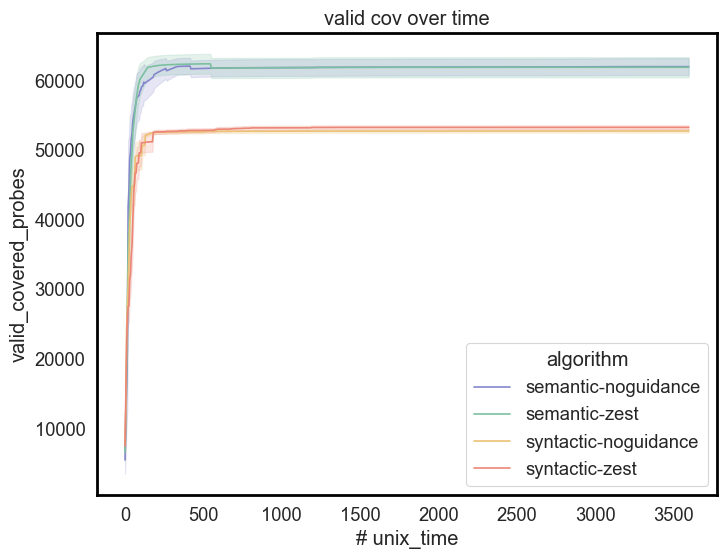

In [17]:
generate_plot_data_base(time_based_plot_data, rolling_time_based_plot_data, "# unix_time", "valid_covered_probes", f"{pdf_dir}valid_cov_over_time.pdf", 'se')


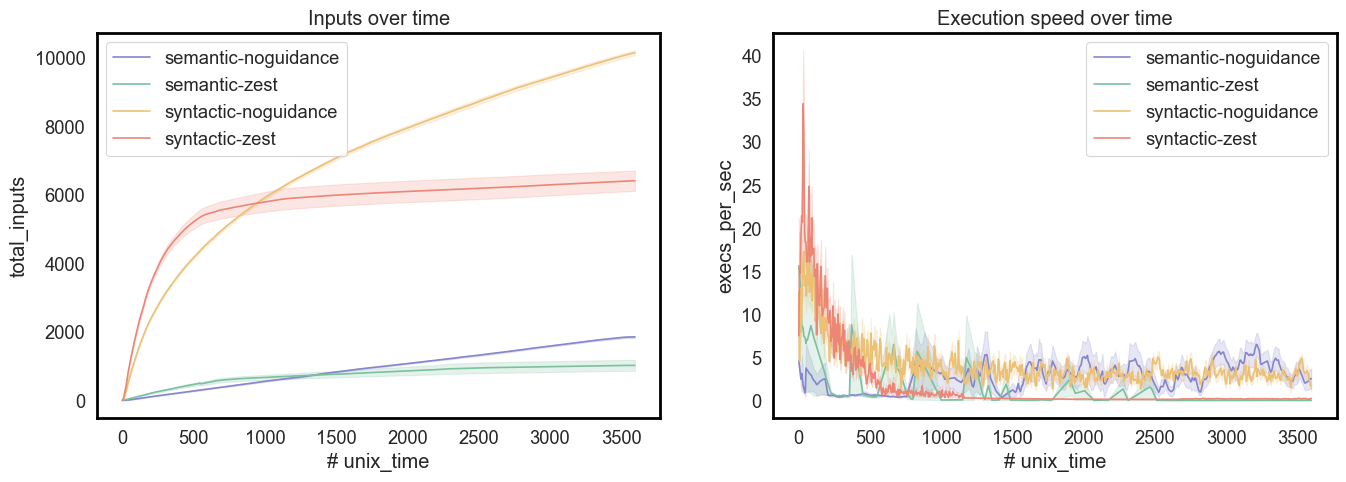

In [18]:
fig, ax1 = plt.subplots(1,2,figsize=(16,5))
x='# unix_time'
lineplot1 = sns.lineplot(x=x, y='total_inputs', hue='algorithm', errorbar="se", hue_order=sorted(time_based_plot_data['algorithm'].unique()), data=time_based_plot_data, ax=ax1[0])
lineplot1.set_title("Inputs over time")
lineplot1.legend(loc='upper left')
lineplot2 = sns.lineplot(x=x, 
                         y='execs_per_sec', 
                         hue='algorithm', 
                         errorbar="se", 
                         hue_order=sorted(time_based_plot_data['algorithm'].unique()), 
                         data=time_based_plot_data, 
                         ax=ax1[1])
lineplot2.set_title("Execution speed over time")
lineplot2.legend(loc='upper right')

path=f"{pdf_dir}/inputs_over_time.pdf"


fig.savefig(path)


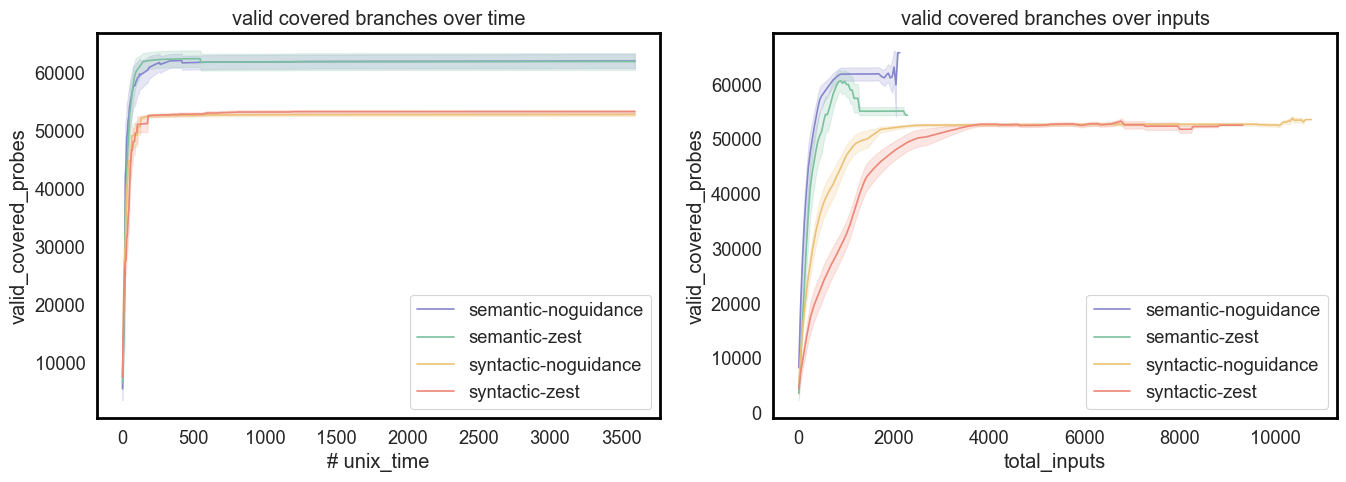

In [19]:
fig, ax1 = plt.subplots(1,2,figsize=(16,5))
x='# unix_time'
lineplot1 = sns.lineplot(x=x, y='valid_covered_probes', 
                         hue='algorithm',
                         errorbar="se",
                         hue_order=sorted(time_based_plot_data['algorithm'].unique()), 
                         data=time_based_plot_data, 
                         ax=ax1[0])
lineplot1.set_title("valid covered branches over time")
lineplot1.legend(loc='lower right')
x2='total_inputs'
lineplot2 = sns.lineplot(x=x2, 
                         y='valid_covered_probes', 
                         hue='algorithm', 
                         hue_order=sorted(count_based_plot_data['algorithm'].unique()), 
                         errorbar="se",
                         data=count_based_plot_data, 
                         ax=ax1[1])
lineplot2.set_title("valid covered branches over inputs")
lineplot2.legend(loc='lower right')

path=f"{pdf_dir}/covered_probes_time_and_inputs.pdf"


fig.savefig(path)


In [20]:
#generate_plot_data_base(time_based_plot_data, rolling_time_based_plot_data, "# unix_time", "valid_inputs" , f"{pdf_dir}valid_inputs_over_time.pdf", errorbrar)

#generate_plot_data_base(time_based_plot_data, rolling_time_based_plot_data, "# unix_time", "invalid_inputs" , f"{pdf_dir}invalid_inputs_over_time.pdf", errorbrar)
#generate_plot_data_base(time_based_plot_data, rolling_time_based_plot_data, "# unix_time", "all_covered_probes", f"{pdf_dir}all_cov_over_time.pdf", errorbrar)

#generate_plot_data_base(time_based_plot_data, rolling_time_based_plot_data, "# unix_time", "total_inputs" , f"{pdf_dir}inputs_over_time.pdf", errorbrar)
#generate_plot_data_base(time_based_plot_data, rolling_time_based_plot_data, "# unix_time", "valid_inputs", f"{pdf_dir}all_cov_over_time.pdf", errorbrar)

#generate_plot_data_base(time_based_plot_data, rolling_time_based_plot_data, "# unix_time", "unique_crashes", f"{pdf_dir}crashes_over_time.pdf", errorbrar)


In [21]:
#sns.pairplot(rolling_time_based_plot_data)

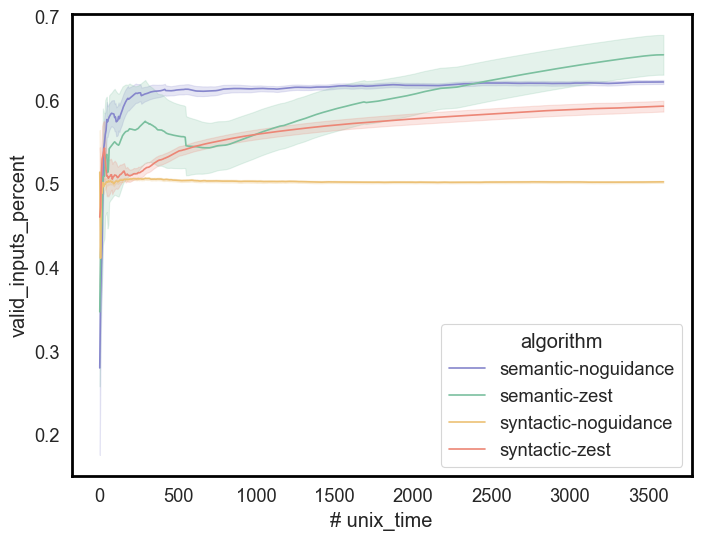

In [22]:
l ,axes  = plt.subplots(figsize=(8,6))
plot= sns.lineplot(time_based_plot_data, 
                 y='valid_inputs_percent',
                 x='# unix_time',
                 hue='algorithm', 
                 errorbar='se',
                 hue_order=sorted(time_based_plot_data['algorithm'].unique()),
                 ax= axes)
'''
sns.lineplot(rolling_time_based_plot_data, 
                 y='valid_inputs_percent',
                 x='# unix_time',
                 hue='algorithm', 
                   errorbar='se',
                 hue_order=ALGORITHM,
                 ax= axes[1])
                 
'''
plot.get_figure().savefig(f"{pdf_dir}/valid_inputs_percent_over_time.pdf")


In [23]:
exceptions_data[10:100]


,exception,unique,count,file,empty,algorithm,run
3,nextflow.exception.ScriptCompilationException,True,3,out1695556630854.nf,NaN,semantic-zest,3
4,nextflow.exception.ScriptCompilationException,True,4,out1695556930198.nf,NaN,semantic-zest,3
0,nextflow.exception.AbortRunException,True,1,out1695559943251.nf,NaN,semantic-zest,4
1,nextflow.exception.ScriptCompilationException,True,1,out1695559972002.nf,NaN,semantic-zest,4
2,nextflow.exception.ScriptCompilationException,True,2,out1695560176011.nf,NaN,semantic-zest,4
...,...,...,...,...,...,...,...
33,groovy.lang.MissingPropertyException,True,23,out1695396538260.nf,NaN,syntactic-zest,0
34,nextflow.exception.ScriptCompilationException,True,9,out1695396538667.nf,NaN,syntactic-zest,0
35,nextflow.exception.ScriptCompilationException,True,10,out1695396539057.nf,NaN,syntactic-zest,0
36,groovy.lang.MissingPropertyException,True,24,out1695396539404.nf,NaN,syntactic-zest,0


In [24]:
for algo in ALGORITHM:
    algo_data = exceptions_data[exceptions_data['algorithm'] == algo]
    #print( algo)
    #print(algo_data['exception'].value_counts())
exceptions_count = exceptions_data.groupby(['exception','algorithm'])['algorithm'].count().to_frame()
print(exceptions_count)

exceptions_count.T

                                                                    algorithm
exception                                     algorithm                      
groovy.lang.MissingPropertyException          semantic-noguidance           3
                                              semantic-zest                 2
                                              syntactic-noguidance      17723
                                              syntactic-zest             6186
nextflow.exception.AbortRunException          semantic-noguidance          20
                                              semantic-zest                14
                                              syntactic-noguidance         20
                                              syntactic-zest               21
nextflow.exception.DuplicateProcessInvocation syntactic-noguidance       1372
                                              syntactic-zest              456
nextflow.exception.ScriptCompilationException semantic-noguidanc

exception groovy.lang.MissingPropertyException                \
algorithm                  semantic-noguidance semantic-zest   
algorithm                                    3             2   

exception                                      \
algorithm syntactic-noguidance syntactic-zest   
algorithm                17723           6186   

exception nextflow.exception.AbortRunException                \
algorithm                  semantic-noguidance semantic-zest   
algorithm                                   20            14   

exception                                      \
algorithm syntactic-noguidance syntactic-zest   
algorithm                   20             21   

exception nextflow.exception.DuplicateProcessInvocation                 \
algorithm                          syntactic-noguidance syntactic-zest   
algorithm                                          1372            456   

exception nextflow.exception.ScriptCompilationException                \
algorithm                           semantic-noguidance semantic-zest   
algorithm                                           199            46   

exception                                      
algorithm syntactic-noguidance syntactic-zest  
algorithm                 5762           1959

C:\Users\Alena\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Alena\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


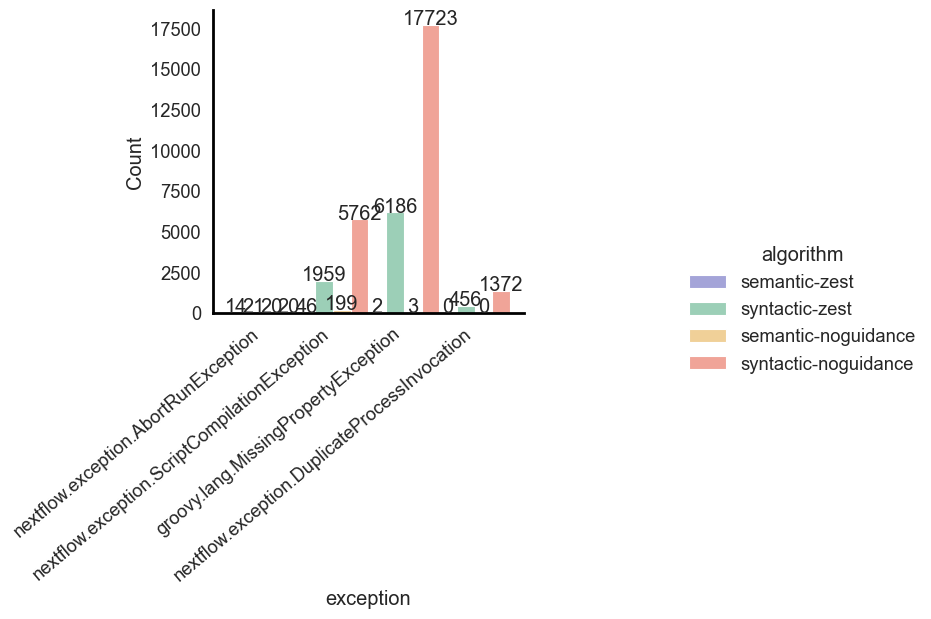

In [25]:
unique=exceptions_data[exceptions_data['unique'] == True]

plot=sns.displot(exceptions_data, x='exception',hue='algorithm', height=4, aspect=1.5, multiple="dodge")
plot.tight_layout()

for ax in plot.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(40)
        label.set_ha('right')
    for p in ax.patches:
        _x = p.get_x() + p.get_width() / 2
        _y = p.get_y() + p.get_height() + 10
        value = str(int(p.get_height()))
        ax.text(_x, _y, value, ha="center")    


plot.savefig(f'{pdf_dir}/exceptions.pdf')

In [26]:
plot.savefig((os.path.join( pdf_dir, "exceptions_logged.pdf" )))

In [27]:
for algo in ALGORITHM:
    algodata = complete_data_frame[complete_data_frame['algorithm']==algo]
    if not algodata.empty: 
        val1 = 0
        val2 = 0
        vt = 0
        val3 = 0
        val4 = 0
        for i in range(RANGE):
            d = algodata[algodata["run"]==i]
            m1 = d['valid_inputs'].max()
            m2 =  d['invalid_inputs'].max()
            mt = d['total_inputs'].max()
            val1+=m1
            val2+=m2
            vt+=mt
            m3=m1/mt
            m4=m2/mt
            v=d['valid_inputs_percent'].max()
            #print(f"algo {algo} run {i} valid:{m1} ({m3}%)  - invalid: {m2} ({m4}%) {v}")
        val3=(val1/vt)*100
        val4=(val2/vt)*100
        print(f" {algo} & {vt} & {val1} ({val3:.2f}\%) & {val2} ({val4:.2f}\%) \\\\ \\ addlinespace")
        print("")

 semantic-zest & nan & nan (nan\%) & nan (nan\%) \\ \ addlinespace

 syntactic-zest & 128246 & 76029 (59.28\%) & 52217 (40.72\%) \\ \ addlinespace

 semantic-noguidance & 37800 & 23477 (62.11\%) & 14323 (37.89\%) \\ \ addlinespace

 syntactic-noguidance & 203037 & 101933 (50.20\%) & 101104 (49.80\%) \\ \ addlinespace



C:\Users\Alena\AppData\Local\Temp\ipykernel_7768\3361208258.py:9: UserWarning: The palette list has more values (20) than needed (14), which may not be intended.
  plot = sns.lineplot(data=unique,


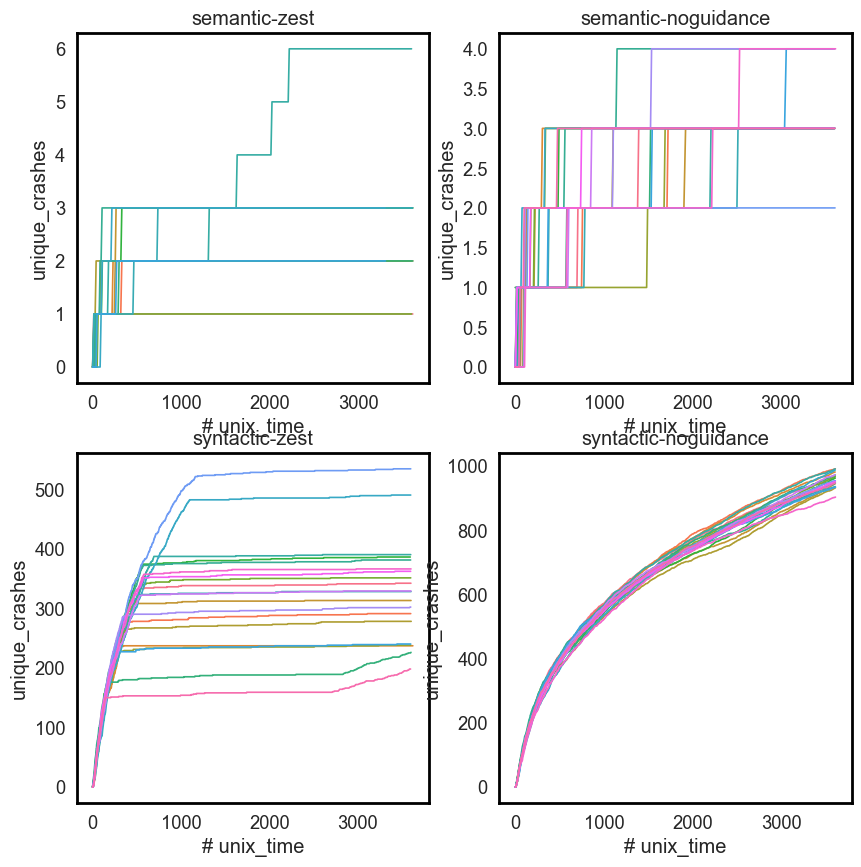

In [28]:
#unique = unique[unique['algorithm'].isin(['semantic-noguidance','semantic-zest'])]
l, axes = plt.subplots(2,2, figsize=(10,10),sharey=False)
i=0
cols = sns.color_palette("husl",20)

algo = 'semantic-zest'
unique=rolling_time_based_plot_data[rolling_time_based_plot_data['algorithm'] == algo]
if not unique.empty: 
    plot = sns.lineplot(data=unique, 
              x='# unix_time',
              y='unique_crashes' ,
              hue='run',
              hue_order=sorted(unique['run'].unique()),
              ax=axes[0,0],
                  palette=cols)
    plot.get_legend().set_visible(False)
    plot.set_title(algo)

algo = 'semantic-noguidance'
unique=rolling_time_based_plot_data[rolling_time_based_plot_data['algorithm'] == algo]
if not unique.empty: 
    plot = sns.lineplot(data=unique, 
              x='# unix_time',
              y='unique_crashes' ,
              hue='run',
              hue_order=sorted(unique['run'].unique()),
              ax=axes[0,1],
                  palette=cols)
    plot.get_legend().set_visible(False)
    plot.set_title(algo)


algo = 'syntactic-zest'
unique=rolling_time_based_plot_data[rolling_time_based_plot_data['algorithm'] == algo]
if not unique.empty: 
    plot = sns.lineplot(data=unique, 
              x='# unix_time',
              y='unique_crashes' ,
              hue='run',
              hue_order=sorted(unique['run'].unique()),
              ax=axes[1,0],
                  palette=cols)
    plot.get_legend().set_visible(False)
    plot.set_title(algo)



algo = 'syntactic-noguidance'
unique=rolling_time_based_plot_data[rolling_time_based_plot_data['algorithm'] == algo]
if not unique.empty: 
    plot = sns.lineplot(data=unique, 
              x='# unix_time',
              y='unique_crashes' ,
              hue='run',
              hue_order=sorted(unique['run'].unique()),
              ax=axes[1,1],
                  palette=cols)
    plot.get_legend().set_visible(False)
    plot.set_title(algo)



In [29]:
l.savefig(os.path.join( pdf_dir, "unique_crashes_per_run.pdf" ))

C:\Users\Alena\AppData\Local\Temp\ipykernel_7768\1525972868.py:10: UserWarning: 
The palette list has fewer values (6) than needed (14) and will cycle, which may produce an uninterpretable plot.
  plot = sns.lineplot(data=unique,
C:\Users\Alena\AppData\Local\Temp\ipykernel_7768\1525972868.py:10: UserWarning: 
The palette list has fewer values (6) than needed (20) and will cycle, which may produce an uninterpretable plot.
  plot = sns.lineplot(data=unique,
C:\Users\Alena\AppData\Local\Temp\ipykernel_7768\1525972868.py:10: UserWarning: 
The palette list has fewer values (6) than needed (20) and will cycle, which may produce an uninterpretable plot.
  plot = sns.lineplot(data=unique,
C:\Users\Alena\AppData\Local\Temp\ipykernel_7768\1525972868.py:10: UserWarning: 
The palette list has fewer values (6) than needed (20) and will cycle, which may produce an uninterpretable plot.
  plot = sns.lineplot(data=unique,


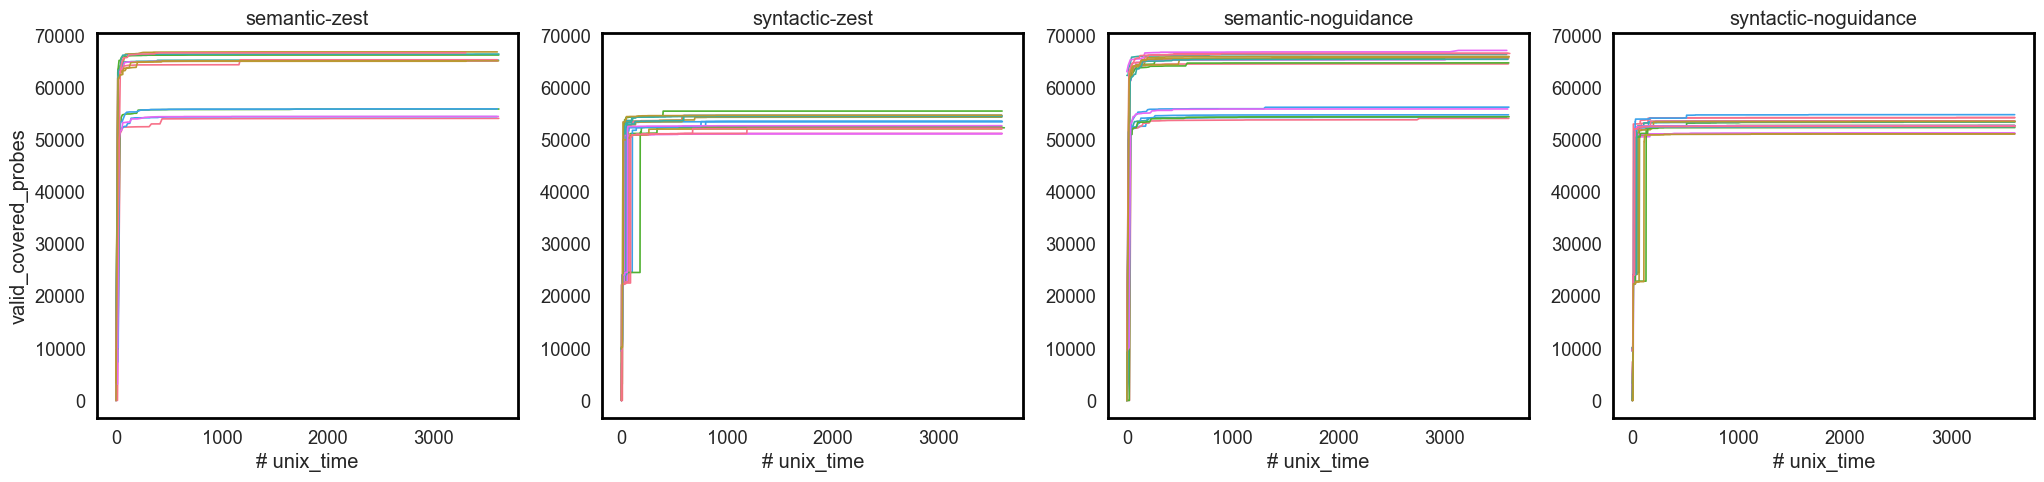

In [30]:
#unique = unique[unique['algorithm'].isin(['semantic-noguidance','semantic-zest'])]
l, axes = plt.subplots(1,4, figsize=(25,5),sharey=True)
i=0
cols = sns.color_palette("husl")

for algo in ALGORITHM:

    unique=rolling_time_based_plot_data[rolling_time_based_plot_data['algorithm'] == algo]
    if not unique.empty: 
        plot = sns.lineplot(data=unique, 
                  x='# unix_time',
                  y='valid_covered_probes' ,
                  hue='run',
                  hue_order=sorted(unique['run'].unique()),
                  ax=axes[i],
                  palette=cols)
        plot.set_title(algo)
        plot.get_legend().set_visible(False)
    i+=1

for ax in l.axes:
    ax.tick_params(axis='y', labelleft=True)
    
l.savefig(os.path.join( pdf_dir, "cov_per_run.pdf" ))


C:\Users\Alena\AppData\Local\Temp\ipykernel_7768\3876187581.py:10: UserWarning: 
The palette list has fewer values (6) than needed (14) and will cycle, which may produce an uninterpretable plot.
  plot = sns.lineplot(data=unique,
C:\Users\Alena\AppData\Local\Temp\ipykernel_7768\3876187581.py:10: UserWarning: 
The palette list has fewer values (6) than needed (20) and will cycle, which may produce an uninterpretable plot.
  plot = sns.lineplot(data=unique,
C:\Users\Alena\AppData\Local\Temp\ipykernel_7768\3876187581.py:10: UserWarning: 
The palette list has fewer values (6) than needed (20) and will cycle, which may produce an uninterpretable plot.
  plot = sns.lineplot(data=unique,
C:\Users\Alena\AppData\Local\Temp\ipykernel_7768\3876187581.py:10: UserWarning: 
The palette list has fewer values (6) than needed (20) and will cycle, which may produce an uninterpretable plot.
  plot = sns.lineplot(data=unique,


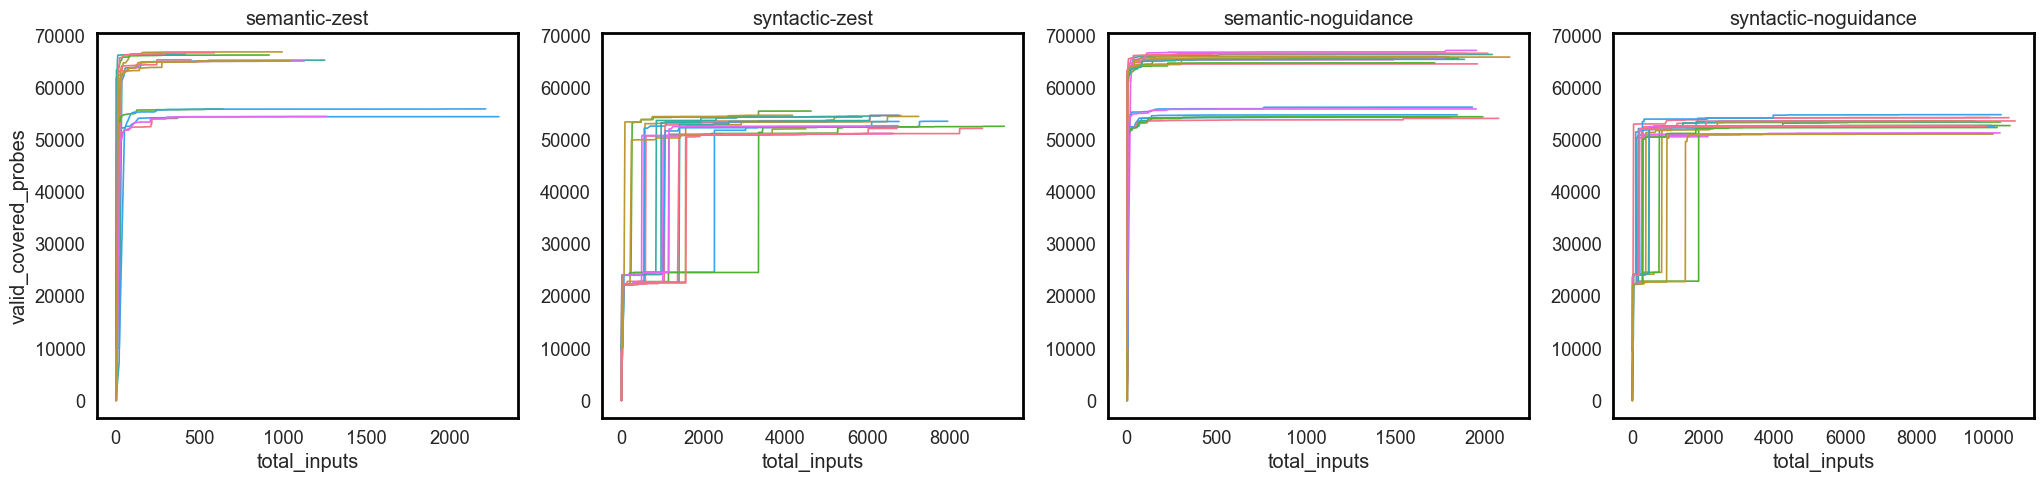

In [31]:
#unique = unique[unique['algorithm'].isin(['semantic-noguidance','semantic-zest'])]
l, axes = plt.subplots(1,4, figsize=(25,5),sharey=True)
i=0
cols = sns.color_palette("husl")

for algo in ALGORITHM:

    unique=rolling_count_based_plot_data[rolling_count_based_plot_data['algorithm'] == algo]
    if not unique.empty: 
        plot = sns.lineplot(data=unique, 
                  x='total_inputs',
                  y='valid_covered_probes' ,
                  hue='run',
                  hue_order=sorted(unique['run'].unique()),
                  ax=axes[i],
                  palette=cols)
        plot.set_title(algo)
        plot.get_legend().set_visible(False)
    i+=1

for ax in l.axes:
    ax.tick_params(axis='y', labelleft=True)
    
l.savefig(os.path.join( pdf_dir, "cov_per_run_over_inputs.pdf" ))


In [32]:
for algo in ALGORITHM:
    df = rolling_time_based_plot_data[rolling_time_based_plot_data['algorithm']==algo]
    print(df.groupby(['run'])['valid_covered_probes'].max())
    des1 =df['valid_covered_probes'].describe()
    des2 = rolling_count_based_plot_data[rolling_time_based_plot_data['algorithm']==algo]['valid_inputs'].describe()
    print(f"-----{algo}----probes")
    print(des1)
    print(f"-----{algo}----inputs")
    print(des2)



run
0     54049
1     66795
2     66196
3     65213
4     54382
5     65042
6     65286
7     65068
8     55845
9     66382
10    55862
11    54424
12    66619
13    65004
Name: valid_covered_probes, dtype: int64
-----semantic-zest----probes
count     3668.000000
mean     61192.482007
std       7157.620696
min          0.000000
25%      55752.750000
50%      65026.500000
75%      65284.000000
max      66795.000000
Name: valid_covered_probes, dtype: float64
-----semantic-zest----inputs
count    3668.000000
mean      482.768266
std       332.422207
min         0.000000
25%       256.000000
50%       434.000000
75%       601.250000
max      1552.000000
Name: valid_inputs, dtype: float64
run
0     51157
1     54287
2     52248
3     54509
4     53419
5     51102
6     54612
7     54429
8     55456
9     54633
10    53504
11    51141
12    52135
13    52038
14    52534
15    54427
16    53457
17    52653
18    52125
19    54645
Name: valid_covered_probes, dtype: int64
-----syntactic-zest---

In [33]:
import scipy.stats as stats
# perform two-sided test. You can use 'greater' or 'less' for one-sided test
df1 = rolling_time_based_plot_data[rolling_time_based_plot_data['generator'].str.match('semantic')].groupby(['run','generator'])['valid_inputs_percent'].last()#
#df1 = time_based_plot_data[time_based_plot_data['algorithm'].str.match('semantic')]['valid_inputs_percent']
df2 = rolling_time_based_plot_data[rolling_time_based_plot_data['generator'].str.match('syntactic')].groupby(['run','generator'])['valid_inputs_percent'].last()
#df2 = time_based_plot_data[time_based_plot_data['algorithm'].str.match('syntactic')]['valid_inputs_percent']
print(stats.mannwhitneyu(x=df1, y=df2, alternative = 'two-sided'))
print(stats.mannwhitneyu(x=df1, y=df2, alternative = 'greater'))
print(stats.mannwhitneyu(x=df1, y=df2, alternative = 'less'))
print(stats.mannwhitneyu(x=df1, y=df2, method = 'exact'))
print(stats.mannwhitneyu(x=df1, y=df2))

print(df1.describe())
print(df2.describe())



MannwhitneyuResult(statistic=400.0, pvalue=6.79561512817336e-08)
MannwhitneyuResult(statistic=400.0, pvalue=3.39780756408668e-08)
MannwhitneyuResult(statistic=400.0, pvalue=0.9999999707854003)
MannwhitneyuResult(statistic=400.0, pvalue=1.4508889103849668e-11)
MannwhitneyuResult(statistic=400.0, pvalue=6.79561512817336e-08)
count    20.000000
mean      0.621200
std       0.010860
min       0.598374
25%       0.612670
50%       0.623359
75%       0.629142
max       0.638342
Name: valid_inputs_percent, dtype: float64
count    20.000000
mean      0.502023
std       0.005564
min       0.491287
25%       0.499640
50%       0.502677
75%       0.506203
max       0.510735
Name: valid_inputs_percent, dtype: float64


In [34]:
rolling_time_based_plot_data[rolling_time_based_plot_data['algorithm'].str.match('semantic')].groupby(['run','algorithm'])['valid_inputs_percent'].max()

run  algorithm          
0    semantic-noguidance    0.745098
     semantic-zest          0.648501
1    semantic-noguidance    0.666667
     semantic-zest          1.000000
2    semantic-noguidance    0.725490
                              ...   
15   semantic-noguidance    0.684211
16   semantic-noguidance    1.000000
17   semantic-noguidance    1.000000
18   semantic-noguidance    1.000000
19   semantic-noguidance    0.723077
Name: valid_inputs_percent, Length: 34, dtype: float64

In [35]:
# perform two-sided test. You can use 'greater' or 'less' for one-sided test

d = complete_data_frame

df1 = d[d['algorithm'].str.match('semantic-noguidance')].groupby(['run'])['valid_inputs_percent'].last()
df2 = d[d['algorithm'].str.match('syntactic-noguidance')].groupby(['run'])['valid_inputs_percent'].last()
print(stats.mannwhitneyu(x=df1, y=df2))
print(df1.describe())
print(df2.describe())

df1 = d[d['algorithm'].str.match('semantic-noguidance')].groupby(['run'])['valid_covered_probes'].last()
df2 = d[d['algorithm'].str.match('syntactic-noguidance')].groupby(['run'])['valid_covered_probes'].last()
print(stats.mannwhitneyu(x=df1, y=df2))
print(df1.describe())
print(df2.describe())

MannwhitneyuResult(statistic=400.0, pvalue=6.79561512817336e-08)
count    20.000000
mean      0.621200
std       0.010860
min       0.598374
25%       0.612670
50%       0.623359
75%       0.629142
max       0.638342
Name: valid_inputs_percent, dtype: float64
count    20.000000
mean      0.502023
std       0.005564
min       0.491287
25%       0.499640
50%       0.502677
75%       0.506203
max       0.510735
Name: valid_inputs_percent, dtype: float64
MannwhitneyuResult(statistic=393.0, pvalue=1.9177119523374596e-07)
count       20.000000
mean     61955.750000
std       5413.135144
min      54050.000000
25%      55579.500000
50%      65445.000000
75%      65869.250000
max      67077.000000
Name: valid_covered_probes, dtype: float64
count       20.000000
mean     52710.550000
std       1126.413333
min      51076.000000
25%      52038.250000
50%      52665.500000
75%      53488.500000
max      54764.000000
Name: valid_covered_probes, dtype: float64


In [36]:
d = complete_data_frame

df1 = d[d['algorithm'].str.match('semantic-zest')].groupby(['run'])['valid_inputs_percent'].last()
df2 = d[d['algorithm'].str.match('semantic-noguidance')].groupby(['run'])['valid_inputs_percent'].last()
print(stats.mannwhitneyu(x=df1, y=df2))
print(df1.describe())
print(df2.describe())


df1 = d[d['algorithm'].str.match('syntactic-zest')].groupby(['run'])['valid_inputs_percent'].last()
df2 = d[d['algorithm'].str.match('syntactic-noguidance')].groupby(['run'])['valid_inputs_percent'].last()
print(stats.mannwhitneyu(x=df1, y=df2))
print(df1.describe())
print(df2.describe())


MannwhitneyuResult(statistic=176.0, pvalue=0.21414757294039755)
count    14.000000
mean      0.656046
std       0.089318
min       0.539813
25%       0.589665
50%       0.645424
75%       0.680414
max       0.877698
Name: valid_inputs_percent, dtype: float64
count    20.000000
mean      0.621200
std       0.010860
min       0.598374
25%       0.612670
50%       0.623359
75%       0.629142
max       0.638342
Name: valid_inputs_percent, dtype: float64
MannwhitneyuResult(statistic=400.0, pvalue=6.79561512817336e-08)
count    20.000000
mean      0.592645
std       0.028866
min       0.515747
25%       0.573714
50%       0.594478
75%       0.610904
max       0.632230
Name: valid_inputs_percent, dtype: float64
count    20.000000
mean      0.502023
std       0.005564
min       0.491287
25%       0.499640
50%       0.502677
75%       0.506203
max       0.510735
Name: valid_inputs_percent, dtype: float64


In [37]:

d = complete_data_frame
df1 = d[d['algorithm'].str.match('semantic-zest')].groupby(['run'])['valid_covered_probes'].last()
df2 = d[d['algorithm'].str.match('semantic-noguidance')].groupby(['run'])['valid_covered_probes'].last()
print(stats.mannwhitneyu(x=df1, y=df2))
print(df1.describe())
print(df2.describe())

df1 = d[d['algorithm'].str.match('syntactic-zest')].groupby(['run'])['valid_covered_probes'].last()
df2 = d[d['algorithm'].str.match('syntactic-noguidance')].groupby(['run'])['valid_covered_probes'].last()
print(stats.mannwhitneyu(x=df1, y=df2))
print(df1.describe())
print(df2.describe())

MannwhitneyuResult(statistic=135.0, pvalue=0.8748766577543728)
count       14.000000
mean     61869.071429
std       5434.323063
min      54049.000000
25%      55849.250000
50%      65055.000000
75%      65968.500000
max      66795.000000
Name: valid_covered_probes, dtype: float64
count       20.000000
mean     61955.750000
std       5413.135144
min      54050.000000
25%      55579.500000
50%      65445.000000
75%      65869.250000
max      67077.000000
Name: valid_covered_probes, dtype: float64
MannwhitneyuResult(statistic=239.0, pvalue=0.29767675447218034)
count       20.000000
mean     53225.550000
std       1365.616902
min      51102.000000
25%      52132.500000
50%      53438.000000
75%      54449.000000
max      55456.000000
Name: valid_covered_probes, dtype: float64
count       20.000000
mean     52710.550000
std       1126.413333
min      51076.000000
25%      52038.250000
50%      52665.500000
75%      53488.500000
max      54764.000000
Name: valid_covered_probes, dtype: float

In [38]:
d=complete_data_frame
a = d[d['algorithm'].str.match('semantic-noguidance')]
b = d[d['algorithm'].str.match('syntactic-noguidance')]

c = d[d['algorithm'].str.match('semantic-zest')]
d = d[d['algorithm'].str.match('syntactic-zest')]

print(a['valid_inputs_percent'].std()) 
print(a.groupby(['run'])['valid_inputs_percent'].last().describe()) 


print(b['valid_inputs_percent'].std())
print(b.groupby(['run'])['valid_inputs_percent'].last().describe())






0.0459383865094238
count    20.000000
mean      0.621200
std       0.010860
min       0.598374
25%       0.612670
50%       0.623359
75%       0.629142
max       0.638342
Name: valid_inputs_percent, dtype: float64
0.015830715199745715
count    20.000000
mean      0.502023
std       0.005564
min       0.491287
25%       0.499640
50%       0.502677
75%       0.506203
max       0.510735
Name: valid_inputs_percent, dtype: float64


In [39]:
d= complete_data_frame
d[d['algorithm'].str.match('syntactic-noguidance')]['valid_inputs_percent'].std()


0.015830715199745715

In [44]:
cv = lambda x: np.std(x, ddof=1) / np.mean(x) * 100

print(cv(c.groupby(['run'])['valid_inputs_percent'].last()) )
print(cv(d.groupby(['run'])['valid_inputs'].last()) )
print(cv(a.groupby(['run'])['valid_inputs'].last()) )
print(cv(b.groupby(['run'])['valid_inputs'].last()) )


13.614611969261759
3.4522409687943822
6.620687986279125
3.4522409687943822
